In [5]:
import os
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import mplcyberpunk

import warnings
warnings.filterwarnings('ignore')

plt.style.use('cyberpunk')

In [7]:
import tensorflow as tf
from keras import layers, Model, optimizers, losses, metrics, callbacks

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from keras import layers, Model, optimizers, losses, metrics, callbacks
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
train_df = pl.read_csv('data/train.csv')
valid_df = pl.read_csv('data/validation.csv')
test_df = pl.read_csv('data/test.csv')

In [11]:
vals_to_take = train_df.filter(pl.col('GeneType') == "scRNA")[0]
valid_df = pl.concat([valid_df, vals_to_take])
train_df = train_df.filter(pl.col("") != 359)

In [12]:
train_df.null_count(), valid_df.null_count(), test_df.null_count()

(shape: (1, 7)
 ┌─────┬────────────┬────────┬─────────────┬──────────┬─────────────────┬────────────────────┐
 │     ┆ NCBIGeneID ┆ Symbol ┆ Description ┆ GeneType ┆ GeneGroupMethod ┆ NucleotideSequence │
 │ --- ┆ ---        ┆ ---    ┆ ---         ┆ ---      ┆ ---             ┆ ---                │
 │ u32 ┆ u32        ┆ u32    ┆ u32         ┆ u32      ┆ u32             ┆ u32                │
 ╞═════╪════════════╪════════╪═════════════╪══════════╪═════════════════╪════════════════════╡
 │ 0   ┆ 0          ┆ 0      ┆ 0           ┆ 0        ┆ 0               ┆ 0                  │
 └─────┴────────────┴────────┴─────────────┴──────────┴─────────────────┴────────────────────┘,
 shape: (1, 7)
 ┌─────┬────────────┬────────┬─────────────┬──────────┬─────────────────┬────────────────────┐
 │     ┆ NCBIGeneID ┆ Symbol ┆ Description ┆ GeneType ┆ GeneGroupMethod ┆ NucleotideSequence │
 │ --- ┆ ---        ┆ ---    ┆ ---         ┆ ---      ┆ ---             ┆ ---                │
 │ u32 ┆ u32       

In [13]:
def format_df(df : pl.DataFrame):
    concat_text = df.with_columns(
        pl.concat_str([
            pl.col('Symbol'),
            pl.col('Description'),
            pl.col('GeneGroupMethod')
        ], separator=" ").alias('Features')
    )

    df = concat_text.select(
        pl.col('Features'),
        pl.col('GeneType')
    )

    return df

In [14]:
train_df = format_df(train_df)
valid_df = format_df(valid_df)
test_df = format_df(test_df)

In [15]:
sk_encoder = OneHotEncoder(sparse_output=False)
sk_vectorizer = TfidfVectorizer()

In [16]:
def create_sklearn_ds(df, encoder, vectorizer, train):
    if train:
        x = vectorizer.fit_transform(df.select('Features').to_series())
        y = encoder.fit_transform(df.select('GeneType'))
    else:
        x = vectorizer.transform(df.select('Features').to_series())
        y = encoder.transform(df.select('GeneType'))
    y = np.argmax(y, axis=1)
    return x, y

sk_x_train, sk_y_train = create_sklearn_ds(train_df, sk_encoder, sk_vectorizer, train=True)
sk_x_valid, sk_y_valid = create_sklearn_ds(valid_df, sk_encoder, sk_vectorizer, train=False)
sk_x_test, sk_y_test = create_sklearn_ds(test_df, sk_encoder, sk_vectorizer, train=False)

In [17]:
def create_keras_ds(df):
    x = df.select('Features').to_numpy()
    y = df.select('GeneType').to_dummies().to_numpy()
    return tf.constant(x, dtype=tf.string), y

k_x_train, k_y_train = create_keras_ds(train_df)
k_x_valid, k_y_valid = create_keras_ds(valid_df)
k_x_test, k_y_test = create_keras_ds(test_df)

In [18]:
sk_models = {
    'RandomForestClassifier' : RandomForestClassifier(),
    'GradientBoostingClassifier' : GradientBoostingClassifier(),
    'LogisticRegression' : LogisticRegression(),
    'LinearSVC' : LinearSVC(),
    'KNeighborsClassifier' : KNeighborsClassifier()
}

In [19]:
preds = {}
accuracies = {}

In [20]:
for sk_model in sk_models:
    current_model = sk_models[sk_model]
    current_model.fit(sk_x_train, sk_y_train)
    current_pred = current_model.predict(sk_x_test)
    preds[sk_model] = current_pred

In [21]:
vectorizer = layers.TextVectorization(
    max_tokens=10000,
    output_mode='tf_idf',
)
vectorizer.adapt(k_x_train)

inputs = layers.Input(shape=(1,), dtype=tf.string)
vectorize_layer = vectorizer(inputs)
x = layers.Dense(units=64, activation='relu')(vectorize_layer)
x = layers.Dense(units=128, activation='relu')(x)
x = layers.Dense(units=64, activation='relu')(x)
x = layers.Dense(units=128, activation='relu')(x)
x = layers.Dropout(rate=0.5)(x)
outputs = layers.Dense(units=10, activation='softmax')(x)

keras_model = Model(inputs, outputs)
keras_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 10000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,250 (2.54 MB)

 Trainable params: 666,250 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
keras_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)

early_stopping = callbacks.EarlyStopping(
    patience=32
)

lr_plataeu = callbacks.ReduceLROnPlateau(
    patience=16
)

keras_history = keras_model.fit(
    x=k_x_train,
    y=k_y_train,
    batch_size=32,
    epochs=20,
    validation_data=(k_x_valid, k_y_valid),
    callbacks=[early_stopping, lr_plataeu]
)

Epoch 1/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - categorical_accuracy: 0.7411 - loss: 0.9137 - val_categorical_accuracy: 0.9214 - val_loss: 0.2559 - learning_rate: 1.0000e-04
Epoch 2/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - categorical_accuracy: 0.9289 - loss: 0.2334 - val_categorical_accuracy: 0.9642 - val_loss: 0.1115 - learning_rate: 1.0000e-04
Epoch 3/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - categorical_accuracy: 0.9647 - loss: 0.1189 - val_categorical_accuracy: 0.9784 - val_loss: 0.0571 - learning_rate: 1.0000e-04
Epoch 4/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - categorical_accuracy: 0.9755 - loss: 0.0761 - val_categorical_accuracy: 0.9814 - val_loss: 0.0458 - learning_rate: 1.0000e-04
Epoch 5/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - categorical_accuracy: 0.9788 - loss: 0.0575 - val_categorical_accuracy: 0.9827 - val_loss: 0.0407 - learning_rate: 1.0000e-04
Epoch 6/20
706/706 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - categorical_accuracy: 0.9803 - loss: 0.0507 - 

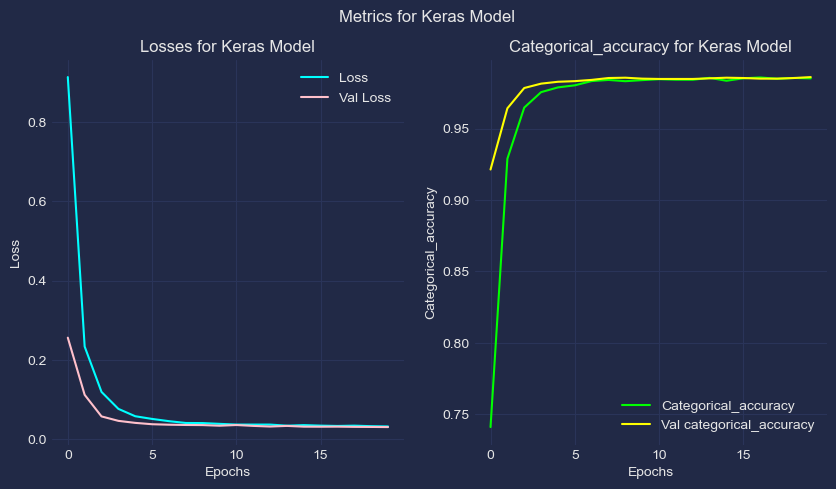

In [23]:
def plot_keras_metrics(hist, metric, colors):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(f'Metrics for Keras Model')
    ax[0].set_title(f'Losses for Keras Model')
    ax[0].set_ylabel(f'Loss')
    ax[0].plot(hist['loss'], color=colors[0], label='Loss')
    ax[0].plot(hist['val_loss'], color=colors[1], label='Val Loss')
    
    ax[1].set_title(f'{metric.capitalize()} for Keras Model')
    ax[1].set_ylabel(f'{metric.capitalize()}')
    ax[1].plot(hist[metric], color=colors[2], label=metric.capitalize())
    ax[1].plot(hist['val_'+metric], color=colors[3], label='Val ' + metric)

    for i in range(2):
        axes = ax[i]
        axes.set_xlabel('Epochs')
        axes.legend()

plot_keras_metrics(
    hist=keras_history.history,
    metric='categorical_accuracy',
    colors=['cyan', 'pink', 'lime', 'yellow']
)

In [24]:
keras_pred = keras_model.predict(k_x_test)
keras_pred = tf.argmax(keras_pred, axis=1)
k_y_test = tf.argmax(k_y_test, axis=1)

preds.update(Keras=keras_pred)
target_names = train_df.select('GeneType').unique().to_numpy().squeeze().tolist()

for model in preds:
    model_pred = preds[model]
    
    if model == 'Keras':
        y_test = k_y_test
    else:
        y_test = sk_y_test

    accuracies[model] = accuracy_score(y_test, model_pred)
    print(f'Classification Report for {model}:\n{classification_report(y_test, model_pred, target_names=target_names)}')

261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report for RandomForestClassifier:
                   precision    recall  f1-score   support

             tRNA       1.00      1.00      1.00      2651
            OTHER       0.98      0.98      0.98       133
BIOLOGICAL_REGION       0.92      0.92      0.92       184
            snRNA       0.99      0.98      0.99      3800
            scRNA       0.99      1.00      1.00       894
             rRNA       0.74      1.00      0.85        72
            ncRNA       0.00      0.00      0.00         1
           PSEUDO       0.79      0.79      0.79        38
           snoRNA       0.97      1.00      0.99       405
   PROTEIN_CODING       0.99      1.00      1.00       148

         accuracy                           0.99      8326
        macro avg       0.84      0.87      0.85      8326
     weighted avg       0.99      0.99      0.99      8326

Classification Report for GradientBoostingClassifier:
                   precisi

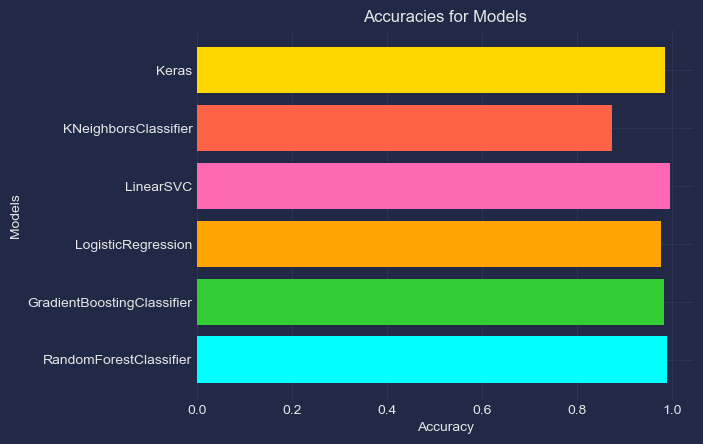

In [28]:
plt.title('Accuracies for Models')
plt.xlabel('Accuracy')
plt.ylabel('Models')
bars = plt.barh(
    list(accuracies.keys()),
    list(accuracies.values()),
    color=['#00FFFF', '#32CD32', '#FFA500', '#FF69B4', '#FF6347', '#FFD700']  # cyan, limegreen, orange, pink, tomato, gold
)

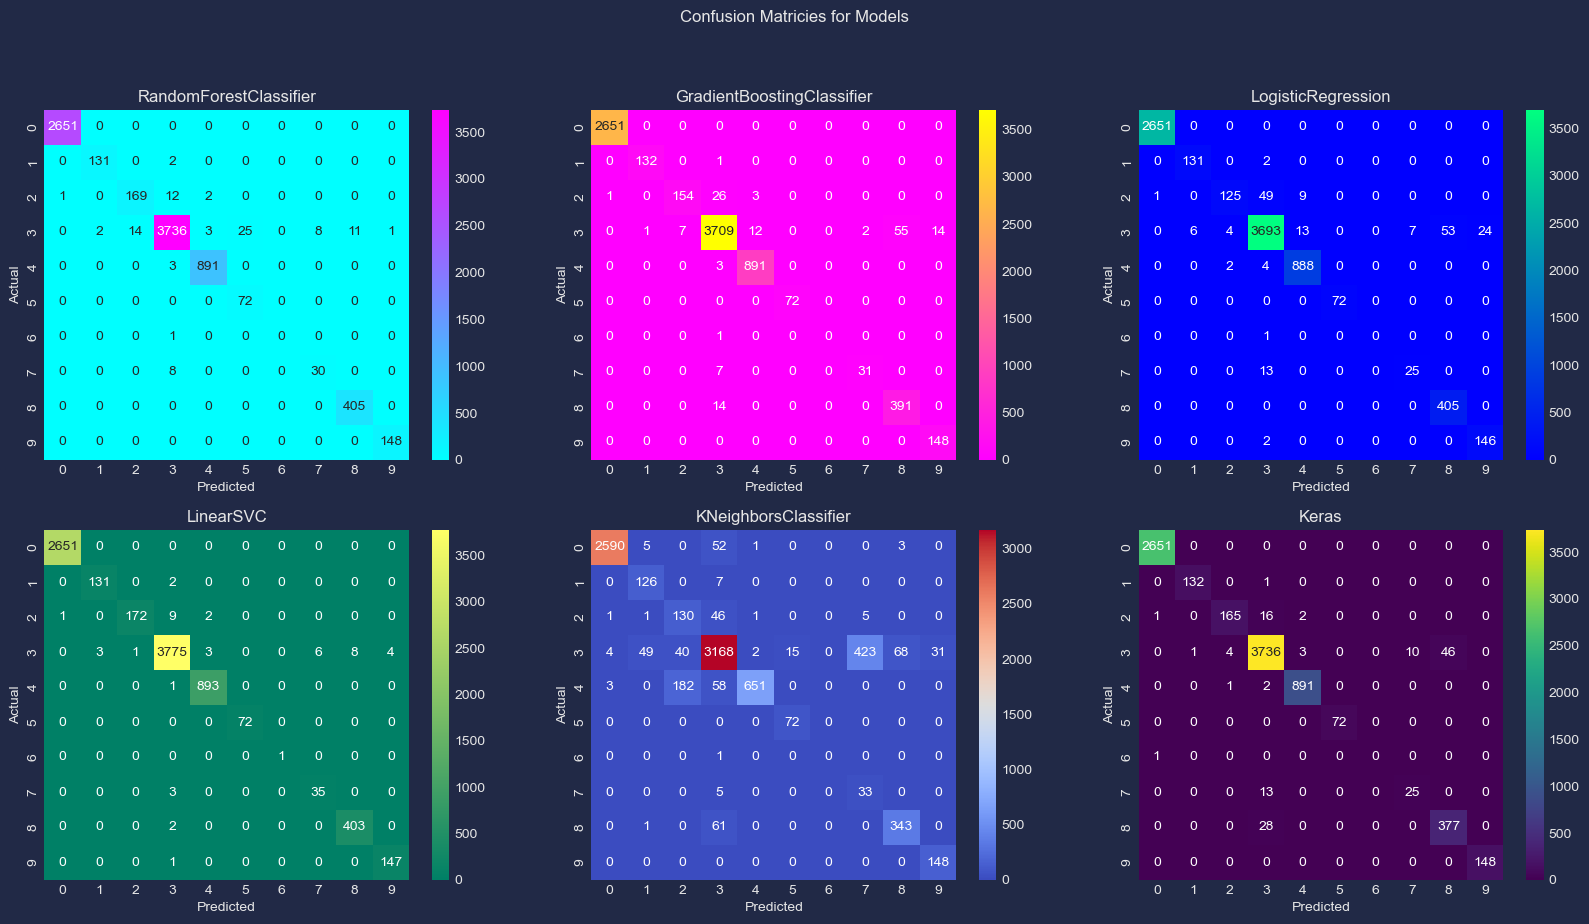

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.suptitle("Confusion Matricies for Models")
cmaps = ['cool', 'spring', 'winter', 'summer', 'coolwarm', 'viridis']

for idx, model in enumerate(preds):
    axes = ax[idx // 3, idx % 3]
    axes.set_title(model)
    model_pred = preds[model]

    if model == 'Keras':
        y_test = k_y_test
    else:
        y_test = sk_y_test
    
    cm = confusion_matrix(y_test, model_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmaps[idx], ax=axes)
    axes.set_ylabel('Actual')
    axes.set_xlabel('Predicted')